# ES Querying

In [109]:
import json, time, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch
%matplotlib inline

### Query

In [110]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])

In [ ]:
es.indices.open(index='corpus1.1')

In [111]:
## Define search query 
search_term = 'brexit'
search_object = {'query': {'match': {'content': search_term}}}

## Applying query term to indexed ES corpus
sch_obj = es.search(index="corpus1.1", body=search_object, size=10000) #Increase returns with size parameter, default 10

In [112]:
## Grabbing the list containing queries 
hits = sch_obj['hits']['hits']
#hits[0]

In [113]:
## Fetching hits' texts, publications, dates

documents = [text['_source']['content'] for text in hits]
publications = [ text['_source']['publication'] for text in hits]
dates = [text['_source']['date'] for text in hits]

In [114]:
## Organize into df

data = pd.DataFrame()

data['documents'] = documents
data['publications'] = publications
data['dates'] = dates

data['dates'] = data.dates.str[:10].astype('datetime64[ns]')
data['dates_period'] = pd.PeriodIndex(data.dates, freq='M')

In [115]:
data.info()
#data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2438 entries, 0 to 2437
Data columns (total 4 columns):
documents       2438 non-null object
publications    2438 non-null object
dates           2438 non-null datetime64[ns]
dates_period    2438 non-null period[M]
dtypes: datetime64[ns](1), object(2), period[M](1)
memory usage: 76.3+ KB


## Sentiment Analysis

In [119]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from textblob import TextBlob
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()

In [120]:
def get_entity_sentences(doc, entity):
    
    """
    Description: Fetch sentences with entities
    Parameters: 
        doc: Document (str)
    Returns: List of sentences containing specificied entity (list)
    """

    sentences = [sent.string.strip() for sent in nlp(doc).sents]
    entity_sentences = [s for s in sentences if entity in s.lower()]        
    
    return entity_sentences

In [121]:
def get_doc_sentiment(doc, method = 'vader', neutrality_thresh = .75, entity = search_term):
       
    """
    Description: Classify document sentiment by calculating sentiment of relevant sentences (0: positive, 1: negative, 2: neutral)
    Parameters: 
        doc: Document to classify (str)
        method: Method to calculate sentiments (str)
    Returns: Average score tuple for list of sentences (tuple)
    """
    
    sentences = get_entity_sentences(doc, entity)
        
    classification = ''
    sent_senti = [0,0,0,0]
    
    if method == 'TextBlob':

        ## Determine sentence sentiment distribution
        
        for s in sentences: 
            
            tb = TextBlob(s).sentiment
                
            if tb.subjectivity > neutrality_thresh: 
                sent_senti[2]+=1         
            else: 
                if tb.polarity > (1 - neutrality_thresh):        
                    sent_senti[0]+=1
                elif tb.polarity < (neutrality_thresh - 1):    
                    sent_senti[1]+=1    
                else:
                    sent_senti[2]+=1
                    
        doc_senti = [x / len(sentences) for x in sent_senti]
        
        if doc_senti[2] > neutrality_thresh:
            classification = 'neutral'
        else:    
            if doc_senti[0] > doc_senti[1]:
                classification = 'negative'
            elif doc_senti[1] > doc_senti[0]: 
                classification = 'positive'   
            else:
                classification = 'neutral'

    elif method == 'vader':
        
        analyser = SentimentIntensityAnalyzer()

        ## Determine sentence sentiment distribution
        
        for s in sentences:  
            
            score = analyser.polarity_scores(s)

            if score['neu'] > neutrality_thresh:
                sent_senti[2]+=1    
            else: 
                if score['compound'] > (1 - neutrality_thresh):        
                    sent_senti[0]+=1        
                elif score['compound'] < (neutrality_thresh -1 ):    
                    sent_senti[1]+=1   
                else:
                    sent_senti[2]+=1 
                    
        doc_senti = [x / len(sentences) for x in sent_senti]
            
        ## Determine document sentiment
        
        if doc_senti[2] > neutrality_thresh:
            classification = 'neutral'

        else:    
            if doc_senti[0] > doc_senti[1]:
                classification = 'positive'
            elif doc_senti[1] > doc_senti[0]: 
                classification = 'negative'  
            else:
                classification = 'neutral' 

    return classification

In [123]:
vader_final, blob_final = ([] for i in range(2))
neutrality_threshold = .75
data = data.head(100)

for i, doc in enumerate(data.documents):
    
    vader_final.append(get_doc_sentiment(doc, method = 'vader', neutrality_thresh =  neutrality_threshold, entity=search_term))
    blob_final.append(get_doc_sentiment(doc, method = 'TextBlob', neutrality_thresh = neutrality_threshold, entity=search_term))
        
    print("Progress: {:2.2%}".format(round(((i/data.shape[0])), 3)), end="\r")

data['vader_final'] = vader_final
data['blob_final'] = blob_final
data.index.name = 'data_index'
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
documents       100 non-null object
publications    100 non-null object
dates           100 non-null datetime64[ns]
dates_period    100 non-null period[M]
vader_final     100 non-null object
blob_final      100 non-null object
dtypes: datetime64[ns](1), object(4), period[M](1)
memory usage: 4.8+ KB


In [124]:
## One-hot encode score columns

dummy_df = pd.get_dummies(data, columns = ['vader_final', 'blob_final'])

#dummy_df['total_final_negative'] = dummy_df[['vader_final_negative', 'blob_final_negative']].mean(axis=1)
#dummy_df['total_final_positive'] = dummy_df[['vader_final_positive', 'blob_final_positive']].mean(axis=1)
#dummy_df['total_final_neutral'] = dummy_df[['vader_final_neutral', 'blob_final_neutral']].mean(axis=1)

dummy_df['total_final_negative'] = dummy_df[['vader_final_negative', 'blob_final_negative']].max(axis=1)
dummy_df['total_final_positive'] = dummy_df[['vader_final_positive', 'blob_final_positive']].max(axis=1)
dummy_df['total_final_neutral'] = dummy_df[['vader_final_neutral', 'blob_final_neutral']].min(axis=1)
dummy_df.to_csv('dummy_df_' + search_term)



In [125]:
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
documents               100 non-null object
publications            100 non-null object
dates                   100 non-null datetime64[ns]
dates_period            100 non-null period[M]
vader_final_negative    100 non-null uint8
vader_final_neutral     100 non-null uint8
vader_final_positive    100 non-null uint8
blob_final_negative     100 non-null uint8
blob_final_neutral      100 non-null uint8
blob_final_positive     100 non-null uint8
total_final_negative    100 non-null uint8
total_final_positive    100 non-null uint8
total_final_neutral     100 non-null uint8
dtypes: datetime64[ns](1), object(2), period[M](1), uint8(9)
memory usage: 4.1+ KB


## Graphing sentiments

In [141]:
dummy_df = pd.read_csv('dummy_df_brexit')
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
data_index              100 non-null int64
documents               100 non-null object
publications            100 non-null object
dates                   100 non-null object
dates_period            100 non-null object
vader_final_negative    100 non-null int64
vader_final_neutral     100 non-null int64
vader_final_positive    100 non-null int64
blob_final_negative     100 non-null int64
blob_final_neutral      100 non-null int64
blob_final_positive     100 non-null int64
total_final_negative    100 non-null int64
total_final_positive    100 non-null int64
total_final_neutral     100 non-null int64
dtypes: int64(10), object(4)
memory usage: 11.0+ KB


In [142]:
#counts = dummy_df['publications'].value_counts()
#dummy_df = dummy_df[~dummy_df['publications'].isin(counts[counts < 200].index)]

dummy_df.publications.value_counts()

Breitbart           24
National Review     14
Reuters             13
Guardian            12
Washington Post      8
Vox                  7
NPR                  6
New York Times       4
New York Post        3
CNN                  3
Business Insider     3
Atlantic             2
Fox News             1
Name: publications, dtype: int64

In [143]:
def publication_sentiments(dummy_df, sentiment):
    
    """
    Description: Converts one-hot encoded article counts dataframe into final publication sentiments df
    Params: One hot encoded df
    Returns: Final publication sentiments dataframe 
    
    """
    lst = []
    pubs = []
    
    master_df = pd.DataFrame()
    master_df['dates_period'] = list(dummy_df.dates_period.sort_values().unique())
    #master_df['publications'] = list(dummy_df.publications.sort_values().unique())

    for i, pub in enumerate(list(dummy_df.publications.unique())):

        ## Filter to specific publication
        temp_df = dummy_df[dummy_df.publications == pub]

        ## Aggregate scores on dates_period
        agg_df = temp_df.groupby('dates_period').agg('sum')
        agg_df['dates_period'] = list(agg_df.index.to_series().astype('str'))
        filt = list(set(agg_df.columns) - set(['dates_period', 'data_index']))
        #agg_df[filt] = agg_df[filt]/dummy_df.publications.value_counts()[pub]
        
        #print(agg_df.info(), "\n")

        cols = ["total_final_" + sentiment]

        lst.append(agg_df[cols].add_suffix('_' + pub))
        pubs.append(pub)

    master_df = pd.concat(lst, axis=1)
    master_df = master_df.fillna(0)

    master_df.head()

    return master_df, pubs


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 2016-03 to 2017-06
Data columns (total 13 columns):
total_final_positive_Breitbart           15 non-null float64
total_final_positive_Guardian            15 non-null float64
total_final_positive_Reuters             15 non-null float64
total_final_positive_National Review     15 non-null float64
total_final_positive_Vox                 15 non-null float64
total_final_positive_Washington Post     15 non-null float64
total_final_positive_NPR                 15 non-null float64
total_final_positive_Atlantic            15 non-null float64
total_final_positive_New York Post       15 non-null float64
total_final_positive_New York Times      15 non-null float64
total_final_positive_Business Insider    15 non-null float64
total_final_positive_Fox News            15 non-null float64
total_final_positive_CNN                 15 non-null float64
dtypes: float64(13)
memory usage: 1.6+ KB
None 

<class 'pandas.core.frame.DataFrame'>
Index: 15 e

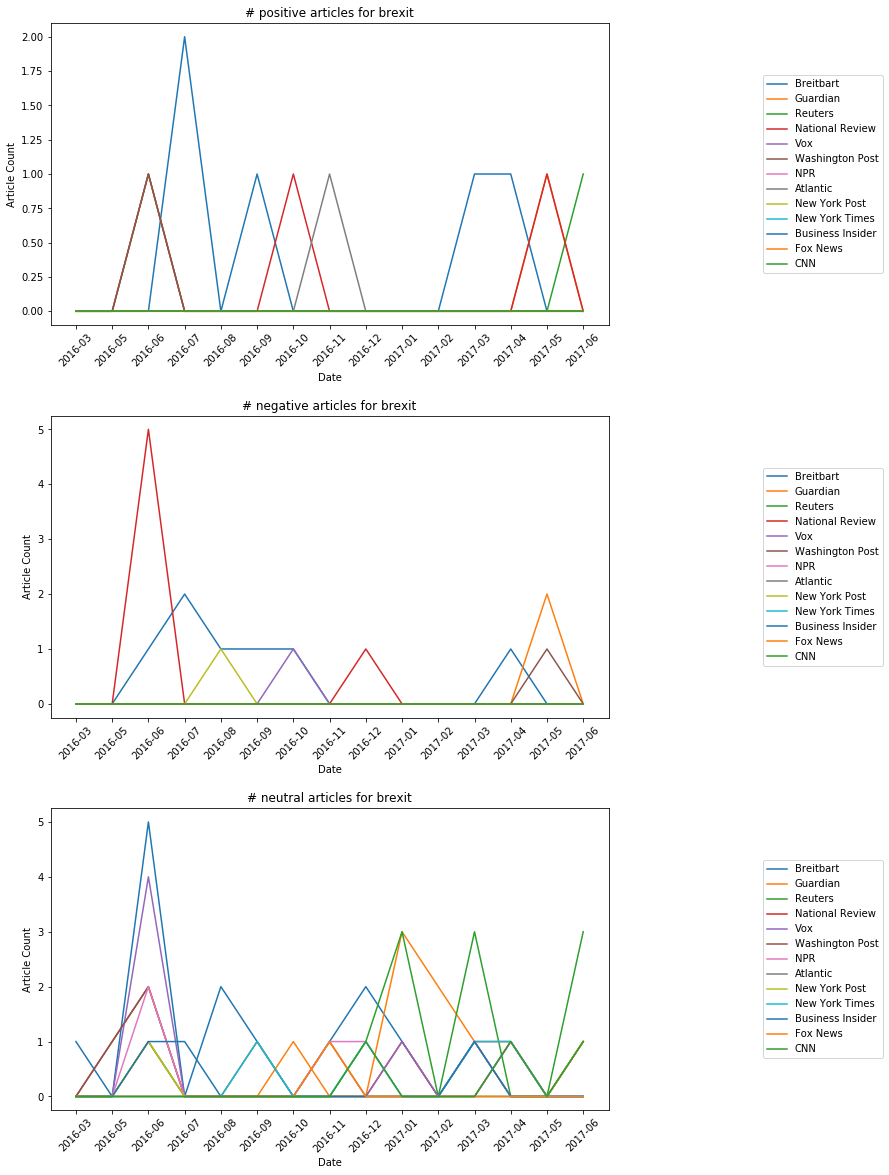

In [144]:
#dummy_df = pd.read_csv('dummy_df_brexit')

fig, axs = plt.subplots(3, 1, figsize=(10, 20))

wspace = 0.3 
hspace = 0.3

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)


for i, sentiment in enumerate(['positive', 'negative', 'neutral']):

    master_df, pubs = publication_sentiments(dummy_df, sentiment)
    print(master_df.info(), "\n")

    for ii, col in enumerate(master_df.columns):
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].plot(master_df.index, master_df[col], label=pubs[ii])
        

    #axs[i].xticks(rotation=70)
    axs[i].set_ylabel('Article Count')
    axs[i].set_xlabel('Date')
    axs[i].legend(loc='right', bbox_to_anchor=(1.5, 0.5))
    axs[i].set_title('# ' + sentiment + ' articles for ' + search_term)
    #axs[i].title("# Positive Articles for " + search_term)




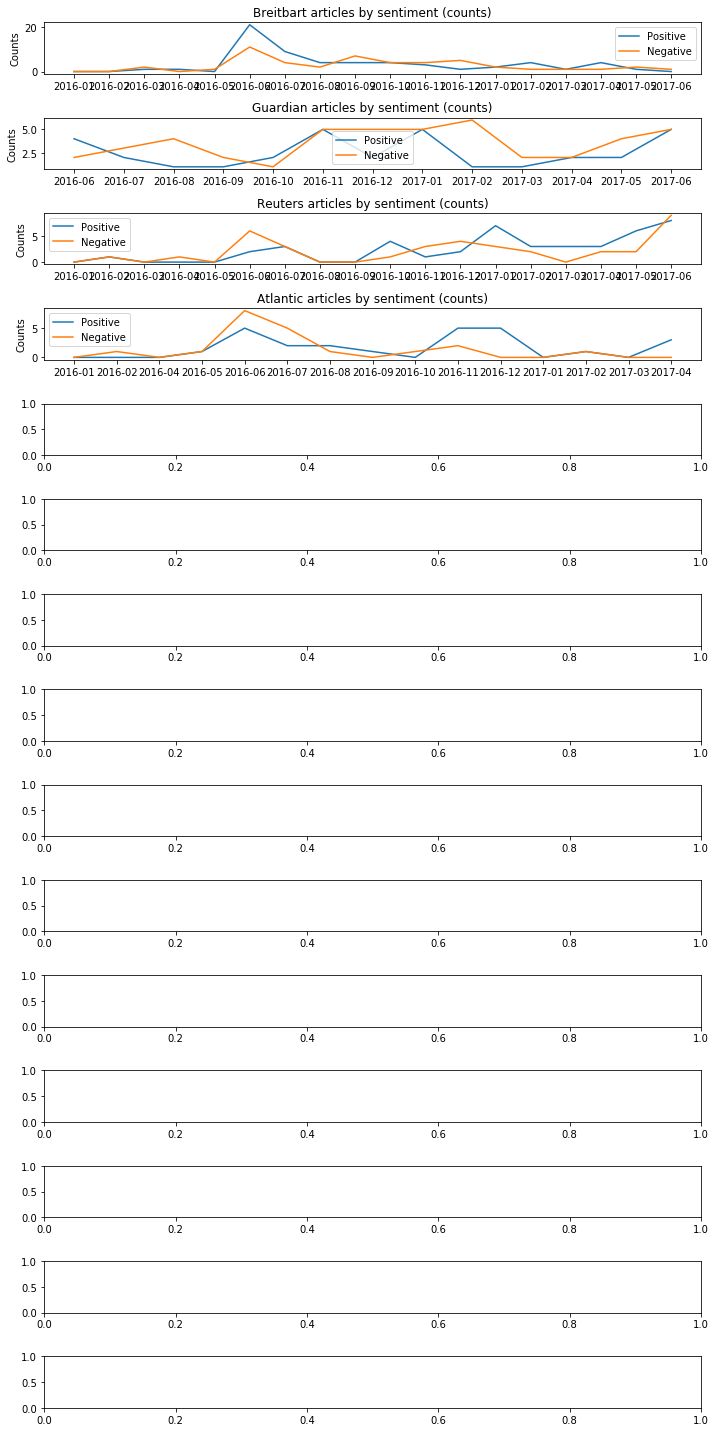

In [104]:

fig, axs = plt.subplots(15, 1, figsize=(10, 20))

for i, pub in enumerate(list(dummy_df.publications.unique())):
    
    ## Filter to specific publication
    graph_df = dummy_df[dummy_df.publications == pub]
    
    ## Aggregate scores on dates_period
    agg_df = graph_df.groupby('dates_period').agg('sum')
    agg_df['dates_period'] = list(agg_df.index.to_series().astype('str'))
        
    axs[i].plot(agg_df['dates_period'], agg_df['vader_final_positive'], label = 'Positive')
    axs[i].plot(agg_df['dates_period'], agg_df['vader_final_negative'], label = 'Negative')
    #axs[i].plot(agg_df['dates_period'], agg_df['vader_final_neutral'], label = 'Neutral')

    axs[i].set_title(pub + ' articles by sentiment (counts)')
    axs[i].set_ylabel('Counts')
    axs[i].legend()

fig.subplots_adjust(top=0.99)
plt.tight_layout()
#fig.suptitle('Article sentiments over time, by publication source', fontsize=12)

plt.show()


## Exploration

### StanfordNLP

In [ ]:
from pycorenlp import StanfordCoreNLP

In [ ]:
!set CORENLP_HOME=" C:\Users\hkhan\OneDrive - LMI\Desktop\Workspace\epic>"

In [ ]:
def get_stanfordnlp_sentiment(sentences):
    
    """
     Description:
     
     Parameters:
       A string of sentences, related in any chosen way.  For example, a document text, a paragraph text, a series of related 
       Sentences, etc.
     Returns:
           out_sentiment:  A 2D list of id, sentence, StanfordNLP score, and decoder values for each sentence
           scores:  A separate list of just StanfordNLP sentiment sentence scores
     Add normalization to the final output scores, as desired, but preferrably after the aggregation step
       0 - very negative
       1 - negative
       2 - neutral
       3 - positive
       4 - very positive
       
    """
    
    vals =  [None, None, None, None]
    out_sentiment = []
    scores = []
    nlp = StanfordCoreNLP('http://localhost:9000')
    res = nlp.annotate(sentences, properties={'annotators': 'tokenize, ssplit, pos, parse, sentiment', 'outputFormat': 'json','timeout': 100000, 'maxCharLength': 300000})
    
    for s in res["sentences"]:
        vals = s["index"], " ".join([t["word"] for t in s["tokens"]]), s["sentimentValue"], s["sentiment"]
        out_sentiment.append(vals)
        scores.append(int(s["sentimentValue"]))
        # print("%d: '%s': %s %s" % (s["index"]," ".join([t["word"] for t in s["tokens"]]), s["sentimentValue"], s["sentiment"]))
    return out_sentiment, scores

In [ ]:
def agg_sentiment_sum(sent_scores):
    
    agg_score=0
    max_score=2
    mid_score=1
    lookup = {
        0: -max_score,
        1: -mid_score,
        2: 0,
        3: mid_score,
        4: max_score
    } # +/-3, since these sentences have larger weight than typical positive or negative sentences
    total = 0
    
    for score in sent_scores:
        agg_score += lookup.get(score, 0)
        # print(str(score) + " " + str(agg_score) + " " + str(lookup.get(score, 0)) + "\n") #debug
    agg_score /= len(sent_scores)   
    return agg_score / max_score

In [ ]:
"""
Generate array of sentiment scores for all documents in "corpus"
On my computer, this was clocking in at a blazing 1.5 documents processed per second.  For the 
entire set of 2582 documents with the 'Bannon' entity, that adds up to a little over an hour of
processing time (for full documents and not for only the relevant sentences).
StanfordNLP is apparently optimized for GPUs...and it's just resource intensive.
Lengthy ones for Bannon:  2546 and 2578
"""

doc_sentiments = []

for i, document in enumerate(data.documents):
    
    _, sent_scores = get_stanfordnlp_sentiment(document)
    doc_sentiments.append(agg_sentiment_sum(sent_scores))
    
    print("Progress: {:2.2%}".format(round(((i/len(data.documents))), 3)), end="\r")
    
    if i % 100 == 0:
        print("Processed " + str(i) + " of " + str(len(documents)) + " documents.")

In [ ]:
sent_output , sent_scores = get_stanfordnlp_sentiment(documents[2546])

### Vader
Article level sentiment analysis using lexical model

In [ ]:
## Initialize Vader analyser
analyser = SentimentIntensityAnalyzer()

positive, negative, neutral, compound = ([] for i in range(4))

## Calculate sentiment scores for each text
for number, i in enumerate(texts):
    
    score = analyser.polarity_scores(i)
    
    positive.append(score['pos'])
    neutral.append(score['neu'])
    negative.append(score['neg'])
    compound.append(score['compound'])

In [ ]:
data['sent_comp'] = compound
data['sent_pos'] = positive
data['sent_neg'] = negative
data['sent_neu'] = neutral

In [ ]:
data.publications.value_counts()

In [ ]:
breitbart_score = data[data.publications == 'Breitbart'].sent_pos.sum()
national_score = data[data.publications == 'National Review'].sent_pos.sum()
fox_score = data[data.publications == 'Fox News'].sent_pos.sum()

cnn_score = data[data.publications == 'CNN'].sent_pos.sum()
npr_score = data[data.publications == 'NPR'].sent_pos.sum()
nyt_score = data[data.publications == 'New York Times'].sent_pos.sum()

print("Positive right-wing scores: \n",
      "Breitbart score: ", breitbart_score, "\n",
      "Fox News Score: ", fox_score, "\n",
      "National Review Score: ", national_score)

print("\nPositive left-wing scores: \n",
      "CNN score: ", cnn_score, "\n",
      "NPR News Score: ", npr_score, "\n",
      "NYT: ", nyt_score)

### ML Approach

Pseudocode

    - Get sentences with relevant entity
    - Use spacy dependecy parser to figure our phrases/sentences that refer to our entity
    - Run sentiment analysis on these phrases, calculate list of sentiments for the entity per document
    - Average the sentiment scores for that document


In [ ]:
document = data['documents'][15]
document

In [ ]:
entity_sentences = get_entity_sentences(document, search_term)
entity_sentences

In [ ]:
example = entity_sentences[-4]
example

In [ ]:
## Textblob example

x = TextBlob(example).sentiment
type(x.polarity)

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

analyser = SentimentIntensityAnalyzer()

score = analyser.polarity_scores(example)

positive = score['pos']
neutral = score['neu']
negative = score['neg']

print('Positive: ', positive, "\nNegative: ", negative, "\nNeutral: ", neutral)

In [ ]:
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
s = flair.data.Sentence(example)
flair_sentiment.predict(s)
total_sentiment = s.labels
total_sentiment

## Dependency Tree Visualizations

In [ ]:
from spacy import displacy

displacy.render(nlp(entity_sentences[12]), style='dep',jupyter=True)

In [ ]:
from nltk import Tree


def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_
    
doc = nlp(entity_sentences[6])
print(doc)

[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]


In [ ]:
for s in sentences_brexit:
    
    s = nlp(s) 
    
    for token in s:
        
        print("Token: ", token, "\n")
        print("\n\tToken.dep_: ", token.dep_, "\n\tToken.head: ", token.head, "\n\tToken.head.dep_: ",  token.head.dep_, "\n")

In [ ]:
import sys
for p in sys.path:
    print(p)

### Useful function calls

In [ ]:
## List indices
es.indices.get_alias("*") 

In [ ]:
## Delete index
es.indices.delete(index='corpus', ignore=[400, 404]) 

In [ ]:
## Fetch document by id
es.get(index = 'corpus1', id=1)


In [ ]:
## Vader snippet test

snippet = ' It amounts, instead, to a deliberate and cynical failure to implement the 2016 referendum result.'
analyser.polarity_scores(snippet)

In [ ]:
scores = np.array([np.array(xi) for xi in scores])
mean_scores = np.mean(scores, axis=0)

In [ ]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.1.0/en_core_web_sm-2.1.0.tar.gz

In [ ]:
s = 'There is currently no indication that the attacker was a Brexit campaigner, and reports over his shout of “Britain First”'
analyser = SentimentIntensityAnalyzer()
score = analyser.polarity_scores(s)
print(score['pos'], score['neg'])

In [ ]:
## Merge in S-NLP sentiments

snlp = pd.read_csv('sentiments_Bannon_Doclevel_noText.csv')
snlp.index.name = 'snlp_index'
#snlp.info()

#merged_df = data.merge(right=snlp[['author', 'stanford_sentiment']], how='left', left_index=True, right_index=True)
merged_df = pd.read_csv('merged_df')

## Normalize stanford-nlp scores
conditions = [
    (merged_df['stanford_sentiment'] > (1 - neutrality_threshold)),
    (merged_df['stanford_sentiment'] < (neutrality_threshold - 1)),
    (merged_df['stanford_sentiment'] > (neutrality_threshold - 1)) & (merged_df['stanford_sentiment'] < (1 - neutrality_threshold))
    ]

choices = [0, 1, 2]
merged_df['stanford_final'] = np.select(conditions, choices, default='2')